---
# TP2 overtone : Effet overtone en temps réel
---

On désire appliquer ce filtre pour effecteur le même effet d'overtone que la chanteuse Ana Maria Hefele. Regardez l'explication sur 
[![](https://i.pinimg.com/originals/fa/fe/6d/fafe6d300d6fa568aed43b31fd3bc67d.jpg)](https://www.youtube.com/watch?v=UHTF1-IhuC0)




# 1 - Un peu de solfège
---

Nous avons besoin de faire le lien entre les fréquences et les notes (regardez le piano de la vidéo et l'échellen des fréquences). Les anglais on remplacé notre DO-RE-MI avec les lettres de l'alphabet A-B-C en commençant avec A pour le LA ! Ce serait trop simple autrement...


 ...| DO| RE| MI| FA|SOL| LA| SI| DO| ...
:-:|:-:|:-:|:-:|:-:|:-:|:-:|:-:|:-:|:-:
 ...| C | D | E | F | G | A | B | C | ...  

## Octave et échelle de fréquence logarithmique
En solfège, une octave correspond à une miltiplication par 2 de la fréquence et au fait de passer d'un DO au DO suivant par exemple. Donc tous les multiples de fréquence en puissance de 2 sonneront en harmonie et donneront la même note mais à des octaves différentes.

Les fréquences multiples qui ne sont pas en puissance de deux apparaissent naturellement (périodicité et séries de Fourier) et les premières harmonique qui ne sont pas des puissance de deux donnent des notes qui sonnent différemment de la note de départ.

Les musiciens occidentaux ont convergés vers "la gammme tempérée" qui décompose une octave (multiplication par deux)  en 12 demitons qui correspondent ainsi chacun à une multiplication par $2^{\frac{1}{12}}\approx 1.0595 \equiv +5.95 \% \approx +\frac{6}{12} dB$. 

On obtient ainsi **une échelle de fréquence logarithmique** qui décompose en 12 demi-tons le passage à l'octave (doublement de fréquence). Un barreau de référrence de cette échelle est le **LA de la 4ème octave noté "LA 4" officiellement à 440 Hz**.

## Les harmoniques qui sonnent bien

Lorsque l'on chante (un DO 4 par exemple) le signal de la voix est quasi-périodique à la fréquence DO4 et comporte naturellement des multiples (Séries de Fourier oblige !). On distingue :
  - DO 4 - $F_0$ - La **fondamentale** (ou harmonique de rang 1)  
  - DO 5 - $F_1 = 2 . F_0$ - La première harmonique (rang 2)
  - SOL 5 - $F_2 = 3 . F_0$ - La deuxième harmonique (rang 3) **quinte juste** est un SOL qui "sonne" différemment du DO. 
  - DO 6 - $F_3 = 4 . F_0$ - La troisième harmonique (rang 4)
  - MI 6 - $F_4 = 5 . F_0$ - La quatrième harmonique (rang 5) **tierce** est un MI qui sonne différemment du DO 
  

La fondamentale n'est pas toujours un DO et on peut vouloir décaler les tons d'une chanson en partant d'une autre note. C'est pourquoi on parle en degrés où la note de degré I est la fondamentale. On répartis ainsi 7 degrés de I à VII dans une octave.

On peut monter la gamme majeure de DO en partant du DO et en faisant des écarts de 2 demi-tons et parfois un seul demi-ton :


Degrés      | I | | II | |  III | IV | | V    |   | VI |  | VII| I   | ...
:----------:|:-:|-|:--:|-|-----:|:---|-|:----:|:-:|:--:|--|---:|:----|:---:
Demitons    | 0 |1| 2  |3|   4  |  5 |6|  7   | 8 | 9  |10| 11 | 12=0| 13=1
Gamme DO maj| DO| | RE | | MI   | FA | | SOL  |   | LA |  | SI | DO  | ...
Gamme FA maj| FA| | SOL| | LA   | LA#| |  DO  |   | RE |  | MI | FA  | ...

La gamme est dite majeure car elle respecte les intervales "ton-ton-demiton-ton-ton-ton-demiton". Cela est culturel et d'autre gamme existent bien sûr.

La gamme tempérée permet presque de représenter les harmoniques x 3 (quinte)  et x 5 (tierce) fidèlement car :
 - la **tierce** à $5.F_0$ donne deux octaves en dessous $F_0<\frac{5.F_0}{4}<2.F_0$ une note de la même octave que la fondamentale.  
   Cette note à $1.25 F_0$ est presque comme 4 demitons au dessus de la fondamentale soit ${2^{\frac{1}{12}}}^4 . F_0 \approx  1.2599 F_0 $.  
   On la nomme **tierce** car elle est de degré III.
- la **quinte** à $3.F_0$ donne une octave en dessous $\frac{3.F_0}{2}$ une note de la même octave que la fondamentale. 
  Cette note à $1.5 . F_0$ est presque 7 demi-tons au dessus de la fondamentale soit $2^{\frac{1}{12}}^7 \approx 1.4983 . F_0$.  
  La **quinte** est appelée ainsi car de degré V.

Ainsi un instrument étant accordé pour jouer une gamme de DO avec la quinte juste sonnera mieux que celui accordé en gamme tempérée. L'intérêt apparait lorsque l'on veut jouer dans une autre gamme :
  - il faudrait réacorder l'instrument pour être exact ! Autrement de gros écarts de fréquences apparaissent.
  - celui en gamme tempérée n'as pas besoin d'être réaccordé et fera globalement de petites erreurs... 


# 2 - Analyse et filtrage hors-ligne
---

On récupère le fichier son `anna_a_mono.wav` où un "aaaaah" est chanté sur le ton d'un DO 4.



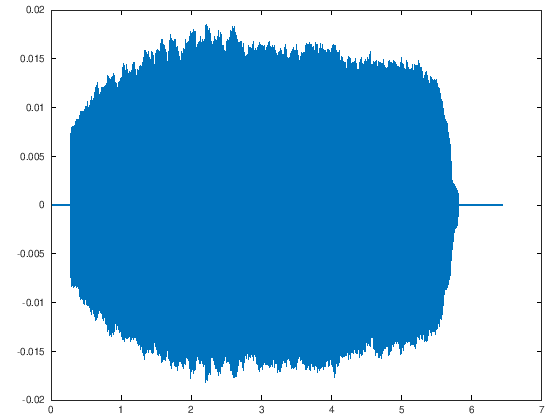

In [119]:
clear all; close all; clc;
racine = pwd; racine = [racine(1:(findstr(racine,"Signal")+6)), "discret/tp/tp1_continu_discret"];cd (racine);


[Y,Fe]=audioread("./anna_a_mono.wav");
s=Y(:,1); % récupère que le son gauche
N=length(s);Te=1/Fe;
t=(1:N);t=t-1;t=t*Te;

plot(t,s)


## Analyse directement aux fréquences intéressantes
---

Inutile de bourriner une `fft` alors que l'on ne veut voir que des fréquences "mélodiques" !

On va construire un **vecteur de fréquences en échelle log** allant du LA2 au LA7 avec 1 points tout les quart de tons.

On construit la matrice de passage en échantillonnant $e^{i2\pi\,f\,t}$ en discret pour ces fréquences comme dans [VEC2 bases fréquentielles](../../cours/notebooks/VEC2_bases_frequentielles.ipynb#Base-fr%C3%A9quentielle-orthogonale-:-TFD) et dans le TD FREQ sur la TFD en matriciel [exo1 TFD corrige](../../td/FREQ_code/exo1_tfd_corr_octave.ipynb#TFD-Matricielle).


In [147]:
LA4=440;
% fenetre audio interessante à regarder
fmin=LA4/4; %LA2 /2^2
fmax=LA4*8; %LA7 *2^3
quart_de_ton = 1/12/4; % 12 demitons dans l'octave (x2) soit 1 en log2
logfreqs=log2(fmin):quart_de_ton:log2(fmax);  

f=2.^logfreqs; M=length(f);

%  ----------> t
% |
% |   W = matrice conjuguée de exp(i.2.pi.f.t)
% V
% f
printf("Construction de la matrice de calcul de TFD (%d x %d) pour les f en échelle log...\n",M,N);
tic;
W =  exp(-i*2*pi*f'*t);
toc
printf("\nCalcul de la TFD : soit %d x %d = %d Mflo (Millions d'opérations flottantes)...\n",length(f),N,N*length(f)/1e6);
tic;
tfd_s = W*s;
toc


Construction de la matrice de calcul de TFD (241 x 283964) pour les f en échelle log...
Elapsed time is 3.70516 seconds.

Calcul de la TFD : soit 241 x 283964 = 68.4353 Mflo (Millions d'opérations flottantes)...
Elapsed time is 0.53168 seconds.


On peut maintenant afficher en échelle temporelle log et gain en dB le module : le spectre.
On ne s'intéresse pas à la phase puisque ce n'est pas un filtre.

On regarde en échelle de fréquence log, puis linéaire.

On utilise le script `afficher_grille_notes` qui est plus haut dans l'orborescence du dépôt `Signal/discret/utiles`.

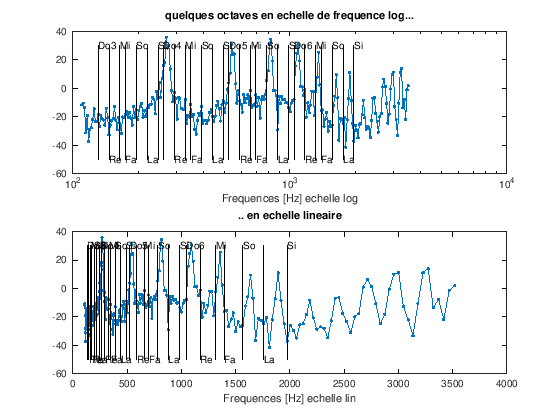

In [148]:
addpath("../../utiles");
dBde = @(gain) 20*log10(abs(gain)) ;

subplot(211)
ax=semilogx(f,dBde(tfd_s),'.-'); 
title("quelques octaves en echelle de frequence log...");
xlabel("Frequences [Hz] echelle log")
hold on;
octaves=afficher_grille_notes();

subplot(212)
plot(f,dBde(tfd_s),'.-'); 
hold on;
afficher_grille_notes(octaves);
title(".. en echelle lineaire")
xlabel("Frequences [Hz] echelle lin")


## Analyse par fft
---

Utilisons l'algorithme `fft` pour afficher ces fréquences.

Attention N points temporel donnent N points en fréquentiel répartis dans $[0, F_e[$.

A vous de créer un vecteur de fréquences linéaire `f_lin` adéquat permettant d'afficher de même manière le module de la fft.



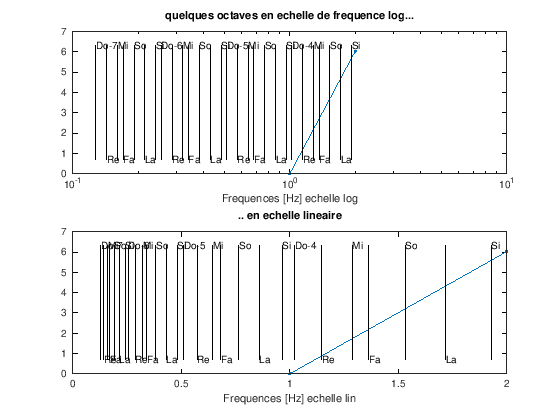

In [154]:
## VOTRE CODE Df=..., f_lin=...
df=1 ;   % La résolution fréquentielle en N points
f_lin = 1:Df:2;  % Les fréquences linéaires

## VOTRE CODE fft_s= ....
# help fft  si nécessaire
# Pourquoi fft n'as pas besoin de connaitre Fe ?!
fft_s = f_lin;    

# On affiche de même le résultat mais avec l'algo fft
# Avec vos fréquences

subplot(211)
ax=semilogx(f_lin,dBde(fft_s),'.-'); 
title("quelques octaves en echelle de frequence log...");
xlabel("Frequences [Hz] echelle log")
hold on;
octaves=afficher_grille_notes();

subplot(212)
plot(f_lin,dBde(fft_s),'.-'); 
hold on;
afficher_grille_notes(octaves);
title(".. en echelle lineaire")
xlabel("Frequences [Hz] echelle lin")


Remarquez alors que le spectre est symétrique par rapport à $\frac{F_e}{2}$ !

Pas étonnant car (sélectionnez la bonne expliquation) :
 - un spectre discret est $F_e/2$-périodique et peut importe que le signal soit réel 
 - un spectre discret est $F_e$-périodique et peut importe que le signal soit réel 
 - un spectre discret est $F_e$-périodique et le signal est réel donc $\hat{S}(-f)=\overline{\hat{S}(f)}$
 - un spectre discret est $F_e/2$-périodique et le signal est réel donc $\hat{S}(-f)=\overline{\hat{S}(f)}$

On peut utiliser `fftshift` pour afficher une période du spectre centrée en 0. 

In [155]:
##VOTRE affichage avec fftshift centré autour de 0 en fréquence

## Quelle harmonique amplifier ?


  
On remarque que la **tierce majeure** donne un MI d'amplitude plus faible que les DO en harmonie et le SOL de la quinte.

On peut choisir d'amplifier soit :
  - la **quinte** pour faire un SOL encore plus fort,
  - la **tierce** qui est déjà faible pour faire apparaître un MI !

On peut d'abord ajuster le filtre continu du second ordre du tp précédent pour qu'il amplifie la **tierce** (4ᵉ harmonique, donc celle de rang 5 à la fréquence $5.F_0$) avec +/- un demi ton de sélectivité ($\zeta$ <0.1).


1) Ajustez $\omega_n$ et $\zeta$ et calculez le gain du second ordre pour les fréquences d'analyse.

2) Multipliez le spectre du signal par celui de votre second ordre pour filtrer.

3) Faites une transformée inverse et généré un fichier son du signal filtré.

Vous mettrez ainsi au point votre fonction de transfert continue pour obtenir le meilleur effet sonore.

> On pourrat accentuer l'effet en appliquant 2 à 3 fois ce filtre !  
> Que devient la fonction de transfert et la réponse harmonique en faisnt cela ?




# 3 - Filtre IIR : bilinéaire
---

Utilisez la synthèse bilinéaire pour fabriquer unfiltre discret équivalent au filtre continu que vous avez ajusté.
  - n'oubliez pas l'effet de compression des fréquences !

  1) Donnez la fonction de transfert 
  2) Affichez la réponse harmonique par dessus le spectre de la voix
  3) Appliquez hors-ligne ce filtre en multipliant puis ifft
  
> Vous pouvez continuer dans ce notebook le travail en utilisant
>   File-> New Console For Notebook
>  Voir les variables en tapant "whos" dans la console
> 

> Vous pouvez exporter ce notebook en scripts `.m` et continuer de travailler
> avec octave ou matlab.
> pour cela dans un terminal lancez la commande

```bash
./genere_les_scripts.sh
cd scripts_octave
octave --gui
```

## 4 - Filtre IIR : récurrence (temps réel)
---

On peut calculer comme si l'on était en temps réel la réponse du filtre en faisant une fonction récursive.

La boucle suivante "simule" un temps réel où à chaque nouvel échantillon, le filtre est calculé avec ce nouveau sample et donne la valeur de la sortie.



In [172]:
%% Fonction pouvant implémenter un filtre IIR de type I
% Implique la mémorisation des x et des y
% cette mémoire est accessible en général par variables globales
global memoires_x
global memoires_y
filtre_iir_I = @(xk) xk; % version stupide de la fonction
%% VOTRE FONCTION dans le fichier filtre_iir_I.m


Ordre = 4 ;               % ordre du filtre
memoires_x = zeros(1,Ordre);   % mémoire du filtre vide au début
memoires_y = memoires_x;

%% Le vecteur des sorties à la même taille que s
y = 0*s;

for k = 1:N
    y(k) = filtre_iir_I(s(k));    
end
